In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import pandas as pd
import scipy.io as io 
import os 
from utils import load_pickle, reward_cutting, filter_data, calc_dist, make_env, load_json
from config import Params
from stable_baselines3 import PPO
from logger import Logger
from scipy.optimize import minimize

logger = Logger.get_logger(__name__)

sns.set_style('whitegrid')
%matplotlib inline

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

18.0


<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

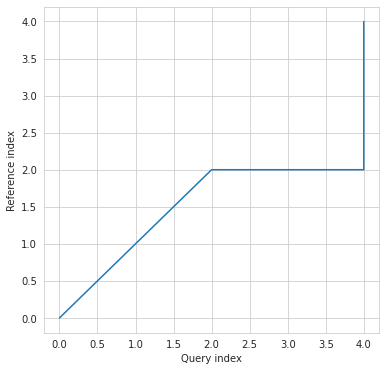

In [2]:
from dtw import dtw
x = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([5, 4, 3, 2, 1]).reshape(-1, 1)
#曼哈顿距离定义，各点相减的绝对值
manhattan_distance = lambda x, y: np.abs(x - y)
#计算出总距离，耗费矩阵，累计耗费矩阵，在矩阵上的路径
aa = dtw(x, y)
print(aa.distance)
aa.plot()

## Fitting with numerical methods

In [63]:
qr1 = (1, 1)
qr2 = (1, 5)
qrt = (1, 3)

g = 2
env1 = make_env('1', q=qr1[0], r=qr1[1], goal=g)
env2 = make_env('2', q=qr2[0], r=qr2[1], goal=g)
envt = make_env('t', q=qrt[0], r=qrt[1], goal=g)
envf = make_env('f', q=qrt[0], r=qrt[1], goal=g)


ppo1 = PPO.load('./1216/q_'+str(qr1[0])+'_r_'+str(qr1[1])+'/Evalpoint/best_model.zip', env=env1)
ppo2 = PPO.load('./1216/q_'+str(qr2[0])+'_r_'+str(qr2[1])+'/Evalpoint/best_model.zip', env=env2)
ppot = PPO.load('./1216/q_'+str(qrt[0])+'_r_'+str(qrt[1])+'/Evalpoint/best_model.zip', env=envt)

s1 = env1.reset() 
s2 = env2.reset() 
st = envt.reset() 
sf = envf.reset() 
step = 0 

S = io.loadmat('./step.mat')['Step']
# S = np.transpose(S, (0, 2, 1))
N = S.shape[0]
M = np.block([
            [np.zeros((N - 1, 1)), np.eye(N - 1)],
            [np.zeros((1, N - 1)), 1]
        ])

y1 = np.zeros((3, 101))
y2 = np.zeros((3, 101))
yf = np.zeros((3, 101))
yt = np.zeros((3, 101))
yk = np.zeros((80, 3))
du1 = np.zeros((3, 100))
du2 = np.zeros((3, 100))
dut = np.zeros((3, 100))

# noise = None 
noise = np.random.normal(0, 0.1, (100, 3))

while True: 
    step += 1 
    if noise is not None: 
        attacked_s1 = s1.copy() 
        attacked_s2 = s2.copy() 
        attacked_st = st.copy()
        attacked_s1[3:6, -1] += noise[step-1, :]
        attacked_s2[3:6, -1] += noise[step-1, :]
        attacked_st[3:6, -1] += noise[step-1, :]
        a1, _ = ppo1.predict(attacked_s1, deterministic=True)
        a2, _ = ppo2.predict(attacked_s2, deterministic=True)
        at, _ = ppot.predict(st, deterministic=True)
    else:
        a1, _ = ppo1.predict(s1, deterministic=True)
        a2, _ = ppo2.predict(s2, deterministic=True)
        at, _ = ppot.predict(st, deterministic=True)
    s1_, r, d, _ = env1.step(a1)
    s2_, r, d, _ = env2.step(a2)
    st_, r, d, _ = envt.step(at)

    y1[:, step] = s1_[:3, -1] - s1_[3:6, -1]
    y2[:, step] = s2_[:3, -1] - s2_[3:6, -1]
    yt[:, step] = st_[:3, -1] - st_[3:6, -1]

    du1[:, step-1] = a1
    du2[:, step-1] = a2
    dut[:, step-1] = at

    if d: 
        break 

    s1 = s1_ 
    s2 = s2_ 
    st = st_ 

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


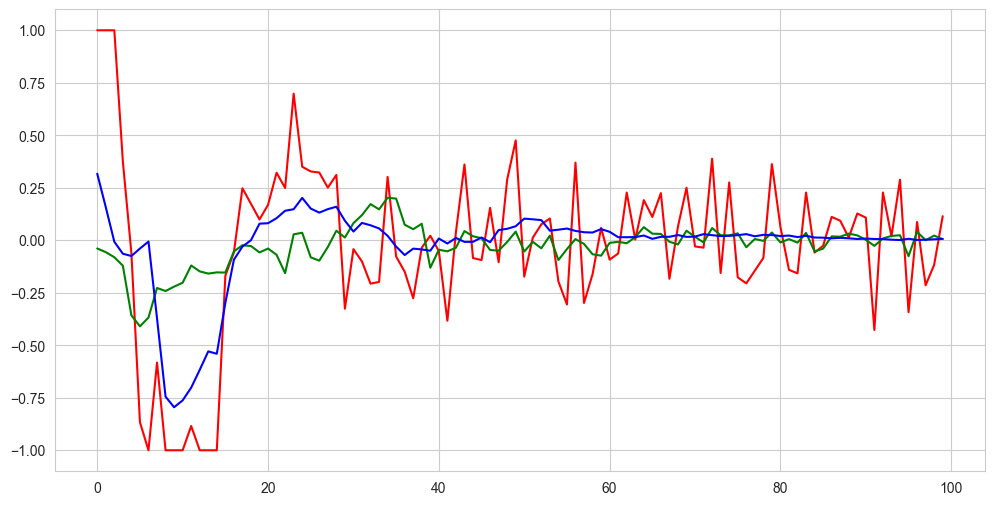

In [64]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(du1.T[:, 1], 'r')
plt.plot(du2.T[:, 1], 'g')
plt.plot(dut.T[:, 1], 'b')
# plt.plot(du12.T[:, 1], 'r--')
# plt.plot(du22.T[:, 1], 'g--')
# plt.plot(dut2.T[:, 1], 'b--')

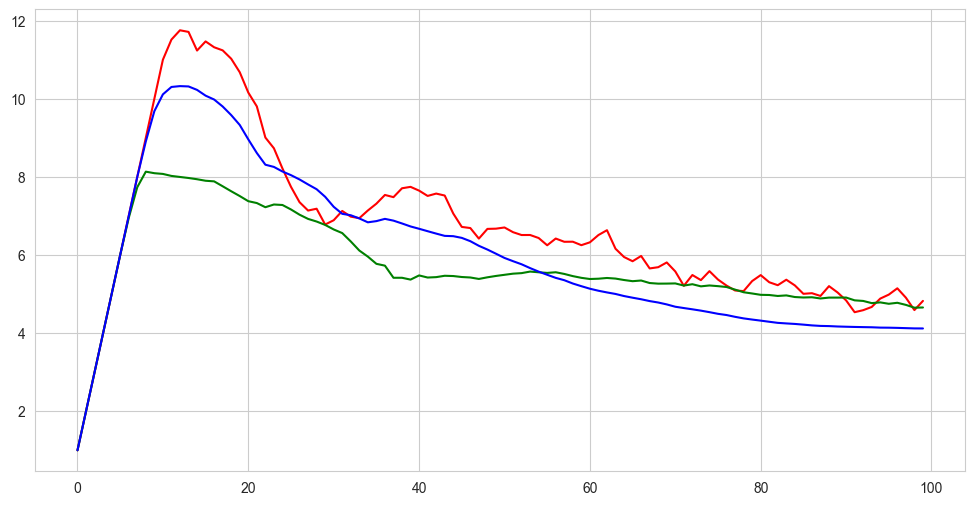

In [65]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(np.cumsum(du1.T[:, 0], axis=0), 'r')
plt.plot(np.cumsum(du2.T[:, 0], axis=0), 'g')
plt.plot(np.cumsum(dut.T[:, 0], axis=0), 'b')

In [58]:
def difference(w, yt, du1, du2, win, ans='norm'):
    '''
    method used to calculate the output of the next sampling time,
    using w to get du = w * du1 + (1 - w) * du2 to be close to yt
    @param w: the sequential parameter to be solved  
    @param yt: target y at the next sampling time
    @param yu: exerted y of each u in the system 
    @param du1: du of the first base agent (smaller)
    @param du2: du of the second base agent (larger)
    @param win: number of window length to avoid overfit
    '''
    # du: n x 3
    w = w.reshape(-1, 3)
    w_ = np.repeat(w, win * [100/win], axis=0)
    du1 = du1.reshape(-1, 3)
    du2 = du2.reshape(-1, 3)
    u1 = np.cumsum(du1, axis=0) * 0.05
    u2 = np.cumsum(du2, axis=0) * 0.05
    # if start_step == 0:
    #     u1 = u1.reshape(-1, 3)
    #     u2 = u2.reshape(-1, 3)
    # else: 
    #     u1 = np.vstack((
    #         u1, u1[-1, :] + du1
    #     ))
    #     u2 = np.vstack((
    #         u2, u2[-1, :] + du2
    #     ))
    u = w_ * u1 + (1 - w_) * u2
    # u = np.zeros(u1.shape)
    # if uf is None: 
    #     for i in range(u1.shape[0]):
    #         u[i, :] = u1[i, :] * w[i, :] + u2[i, :] * (1 - w[i, :])
    #         if i > 0: 
    #             u[i, :] = np.clip(u[i, :], u[i-1, :]-0.05, u[i-1, :]+0.05)

    # du = du1 * w + du2 * (1 - w)
    # if uf is None:
    #     u = np.cumsum(du, axis=0) * 0.05
    # else:
    #     u = np.vstack((
    #         uf, uf[-1, :] + np.cumsum(du, axis=0) * 0.05
    #     ))
        
    # yk = y_current.copy()
    yk = [np.array([0, 0, 0])] 
    yu = np.zeros((3, 3))
    res = []
    for i in range(yt.shape[0]-1):
        res.append(0.9 * np.linalg.norm(yt[i, :] - yk[i]) + 0.1 * np.linalg.norm(yt[i, :] - 1))
        yu1 = np.array([0.9231, 0.9231, 0.8858]) * yu[0, :]
        # u1 -> y1  
        if i >= 6:
            yu1[0] += 0.082 * u[i-6, 0]
        if i >= 7:
            yu1[0] += 0.2312 * u[i-7, 0]
        # u1 -> y2 
        if i >= 4:
            yu1[1] += 0.2113 * u[i-4, 0]
        if i >= 5:
            yu1[1] += 0.2031 * u[i-5, 0]
        # u1 -> y3 
        if i >= 5:
            yu1[2] += 0.5 * u[i-5, 0]
        
        yu2 = np.array([0.9355, 0.9355, 0.9131]) * yu[1, :]
        # u2 -> y1  
        if i >= 7:
            yu2[0] += 0.1142 * u[i-7, 1]
        # u2 -> y2 
        if i >= 3:
            yu2[1] += 0.1875 * u[i-3, 1]
        if i >= 4:
            yu2[1] += 0.1814 * u[i-4, 1]
        # u2 -> y3 
        if i >= 5:
            yu2[2] += 0.1964 * u[i-5, 1]
        if i >= 6:
            yu2[2] += 0.1877 * u[i-6, 1]

        yu3 = np.array([0.9231, 0.9048, 0.8102]) * yu[2, :]
        # u3 -> y1  
        if i >= 6:
            yu3[0] += 0.1164 * u[i-6, 2]
        if i >= 7:
            yu3[0] += 0.3356 * u[i-7, 2]
        # u3 -> y2 
        if i >= 3:
            yu3[1] += 0.1704 * u[i-3, 2]
        if i >= 4:
            yu3[1] += 0.4863 * u[i-4, 2]
        # u3 -> y3 
        yu3[2] += 1.367 * u[i, 2]

        yu = np.array([yu1, yu2, yu3])
        yk.append(yu1 + yu2 + yu3)
    if ans == 'norm':
        return np.sum(res)
    elif ans == 'info':
        '''
        return yk, yu
        '''
        return np.stack(yk), u, res

win = 5
step = 100
y_target = yt.T[:step, :]
du_1 = du1.T[:step, :]
du_2 = du2.T[:step, :]
x0 = np.ones((win, 3)) * 0.5  

def cons1(x, du1, du2, win):
    u1 = np.cumsum(du1, axis=0) * 0.05
    u2 = np.cumsum(du2, axis=0) * 0.05
    x = x.reshape(-1, 3)
    x_ = np.repeat(x, win * [100/win], axis=0)
    u = x_ * u1 + (1 - x_) * u2
    du = u[1:, :] - u[:-1, :]
    return -np.prod(0.05-du+1e-8>0) - np.prod(du+0.05+1e-8>0) + 2 - 1e-8

def cons2(x):
    x = x.reshape(-1, 3)
    dx = np.abs(x[1:, :] - x[:-1, :])
    print(np.prod(0.5-dx+1e-8>0) == 1)
    return np.prod(0.5-dx+1e-8>0)

con1 = {
    'type': 'ineq',
    'fun': cons1,
    'args': (du1.T, du2.T, win)
}

con2 = {
    'type': 'ineq',
    'fun': cons2,
}

res = minimize(
    fun=difference,
    x0=x0,
    args=(yt.T, du1.T, du2.T, win, 'norm'),
    method='SLSQP',
    bounds=tuple([(0, 1) for _ in range(np.prod((win, 3)))]),
    constraints=(con1),
    # options={'maxiter':300, 'disp':True}
)

res.x.reshape(-1, 3)
# res

array([[5.53702304e-01, 5.18372730e-01, 5.92882468e-01],
       [1.85704079e-01, 8.32357384e-01, 6.42188535e-01],
       [5.08706359e-01, 0.00000000e+00, 2.85143088e-01],
       [2.70276455e-01, 2.43407379e-13, 0.00000000e+00],
       [1.96790888e-01, 3.51625011e-02, 3.74042340e-01]])

In [66]:
yk, u, r = difference(res.x.reshape(-1, 3), yt.T, du1.T, du2.T, win, ans='info')

In [67]:
w = res.x.reshape(-1, 3)

In [68]:
e = np.sum(np.abs(yk - yt.T))
print('error: {:.2f}'.format(e))

error: 14.32


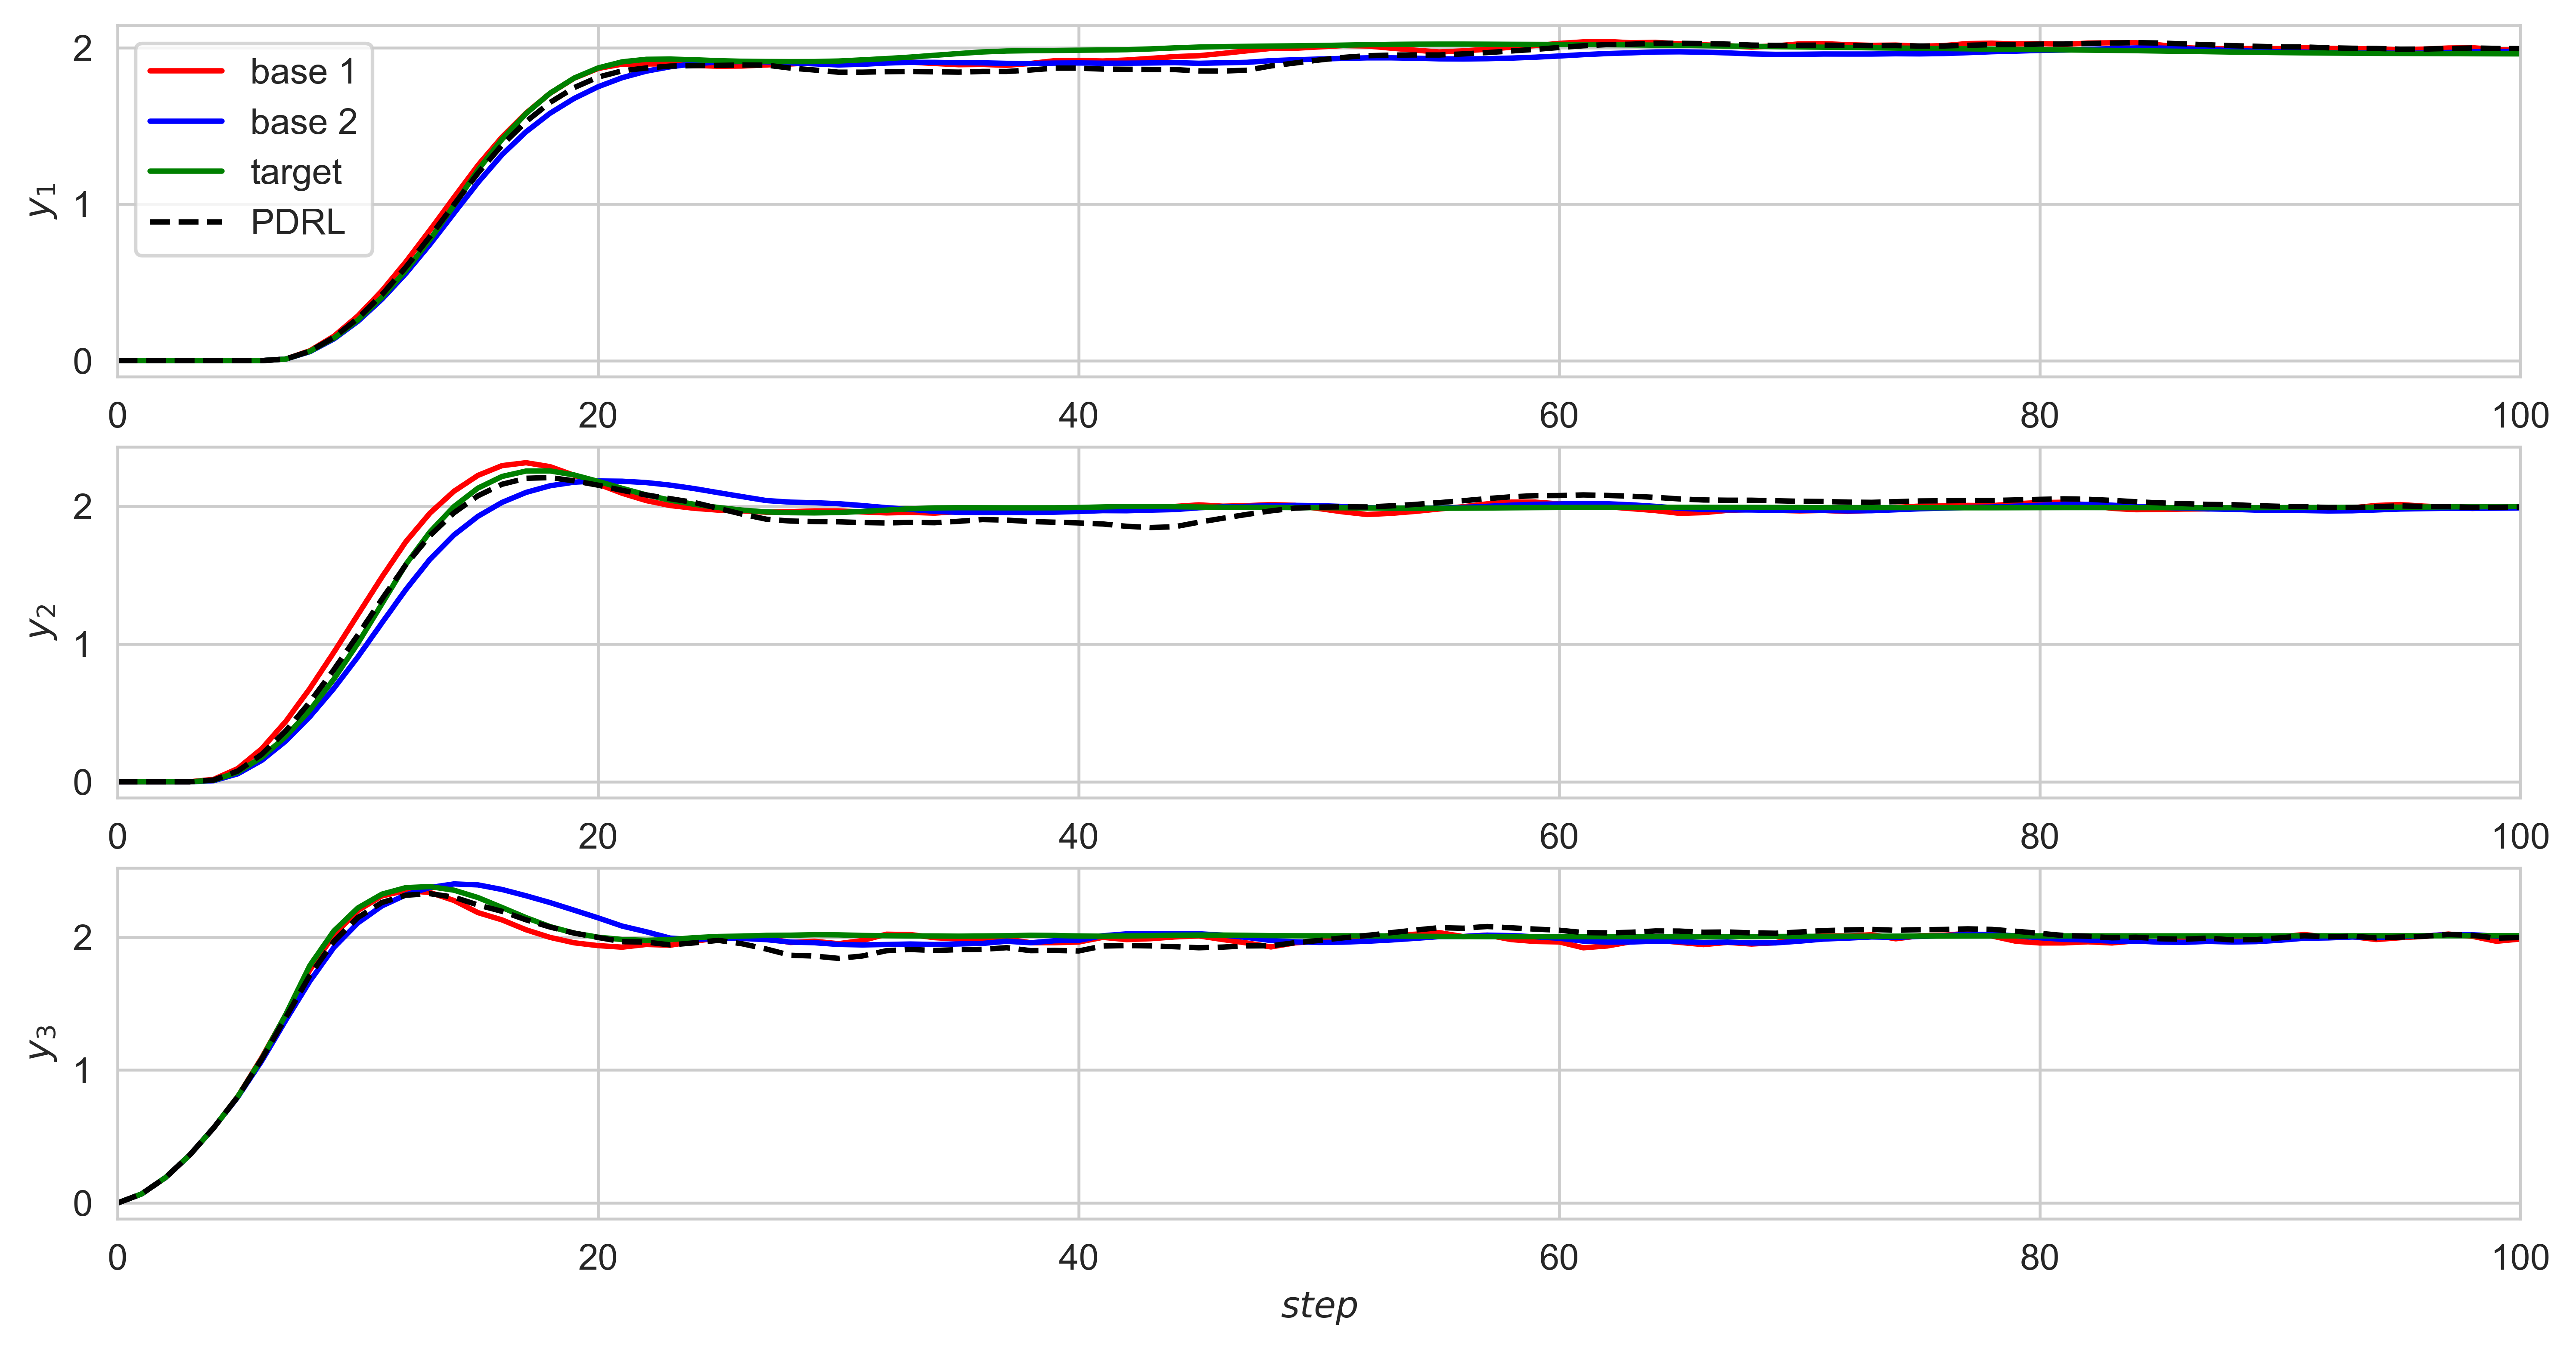

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(12, 6), dpi=600)
axs[0].plot(y1.T[:, 0], color='r', label='base 1')
axs[0].plot(y2.T[:, 0], color='b', label='base 2')
axs[0].plot(yt.T[:, 0], color='g', label='target')
axs[0].plot(yk[:, 0], color='black', linestyle='--', label='PDRL')
axs[0].set_ylabel('$y_1$')

axs[1].plot(y1.T[:, 1], color='r')
axs[1].plot(y2.T[:, 1], color='b')
axs[1].plot(yt.T[:, 1], color='g')
axs[1].plot(yk[:, 1], color='black', linestyle='--')
axs[1].set_ylabel('$y_2$')

axs[2].plot(y1.T[:, 2], color='r')
axs[2].plot(y2.T[:, 2], color='b')
axs[2].plot(yt.T[:, 2], color='g')
axs[2].plot(yk[:, 2], color='black', linestyle='--')
axs[2].set_ylabel('$y_3$')
axs[2].set_xlabel('$step$')

axs[0].legend()

for ax in axs:
    ax.set_xlim([0, 100])
    # ax.set_ylim([0, 1.2])

# plt.figure(figsize=(3, 3), dpi=300)
# plt.plot(y1.T[:, 0], color='r', label='base 1')
# plt.plot(y2.T[:, 0], color='b', label='base 2')
# plt.plot(yt.T[:, 0], color='g', label='PDRL')
# plt.plot(yk[:, 0], color='black', linestyle='--', label='target')
# plt.xlim([10, 30])
# plt.ylim([0.2, 1.1])
# plt.xticks([8, 16, 24])
# plt.yticks([0.4, 0.7, 1.0, 1.1])


# Parametric 

In [ ]:
q1, r1 = (10, 1)
q2, r2 = (1, 10)
qt, rt = (1, 1)

env1 = make_env("1", q=q1, r=r1)
env2 = make_env("2", q=q2, r=r2)
envf = make_env("1", q=qt, r=rt)
envt = make_env("2", q=qt, r=rt)

args = Params(adversary_attack=False)

ppo1 = PPO(
    env=env1,
    q=q1,
    r=r1,
    args=args,
    logger=logger,
)
ppo2 = PPO(
    env=env2,
    q=q2,
    r=r2,
    args=args,
    logger=logger,
)
ppot = PPO(
    env=envt,
    q=qt,
    r=rt,
    args=args,
    logger=logger,
)
ppo1._load_model()
ppo2._load_model()
ppot._load_model()

# q1, r1 = (env1.q[0], env1.r[0])
# q2, r2 = (env2.q[0], env2.r[0])
# qt, rt = (envt.q[0], envt.r[0])

# use [5, 1], [1, 2] to fit [1, 1]
d1 = calc_dist((q1, r1), (qt, rt), method='log')
d2 = calc_dist((q2, r2), (qt, rt), method='log')
w1 = d2 / (d1 + d2)
w2 = d1 / (d1 + d2)

print('weight: {}, {}'.format(w1, w2))

y1, y2, yf, yt = [], [], [], [] 
du1, du2, duf, dut = [], [], [], []
epi_r1, epi_r2, epi_rf, epi_rt = [0], [0], [0], [0] 

args = Params()
s1 = env1.reset()
s2 = env2.reset()
sf = envf.reset() 
st = envt.reset() 

step = 0

y_error = [0]

if args.adversary_attack_var:
    noise = np.random.normal(np.zeros((3,)), args.adversary_attack_var)
    # env 1 
    attacked_s1 = s1.copy() 
    attacked_s1[3:6, -1] += noise 
    # env 2 
    attacked_s2 = s2.copy() 
    attacked_s2[3:6, -1] += noise
    attacked_sf = sf.copy() 
    attacked_sf[3:6, -1] += noise
    attacked_st = st.copy() 
    attacked_st[3:6, -1] += noise
    
while True:
    step += 1
    y1.append(env1.y.reshape(1, -1))
    y2.append(env2.y.reshape(1, -1))
    yf.append(envf.y.reshape(1, -1))
    yt.append(envt.y.reshape(1, -1))

    if args.adversary_attack_var:
        a1, log_prob1 = ppo1.policy.choose_action(attacked_s1)
        a2, log_prob2 = ppo2.policy.choose_action(attacked_s2)
        af1, _ = ppo1.policy.choose_action(attacked_sf)
        af2, _ = ppo2.policy.choose_action(attacked_sf)
        at, log_probt = ppot.policy.choose_action(attacked_st)
    else:
        a1, log_prob1 = ppo1.policy.choose_action(s1)
        a2, log_prob2 = ppo2.policy.choose_action(s2)
        af1, _ = ppo1.policy.choose_action(sf)
        af2, _ = ppo2.policy.choose_action(sf)
        at, log_probt = ppot.policy.choose_action(st)
    af = w1 * a1 + w2 * a2

    s1_, _, done, _ = env1.step(a1)
    s2_, _, done, _ = env2.step(a2)
    sf_, _, done, _ = envf.step(af)
    st_, _, done, _ = envt.step(at)

    du1.append(a1)
    du2.append(a2)
    duf.append(af)
    dut.append(at)

    y_error.append(y_error[-1] - np.sum(np.abs(sf_[3:6, -1] - st_[3:6, -1])))

    # epi_r1.append(epi_r1[-1] + r1)
    # epi_r2.append(epi_r2[-1] + r2)
    # epi_rf.append(epi_rf[-1] + rf)
    # epi_rt.append(epi_rt[-1] + rt)


    if args.adversary_attack_var:
        noise = np.random.normal(np.zeros((3,)), args.adversary_attack_var)
        # env 1 
        attacked_s1_ = s1_.copy() 
        attacked_s1_[3:6, -1] += noise 
        # env 2 
        attacked_s2_ = s2_.copy() 
        attacked_s2_[3:6, -1] += noise
        # env fitting
        attacked_sf_ = sf_.copy() 
        attacked_sf_[3:6, -1] += noise
        # env trained 
        attacked_st_ = st_.copy() 
        attacked_st_[3:6, -1] += noise

        # if step == 1:
        #     print(a1, s1_)
        #     print('------------------------------')
        #     print(attacked_s1_)
        #     print('-------------------------')
        #     print(np.hstack((
        #         attacked_s1[:, 1:],
        #         attacked_s1_[:, -1].reshape(-1, 1)
        #     )))

        attacked_s1 = attacked_s1_
        attacked_s2 = attacked_s2_
        attacked_sf = attacked_sf_
        attacked_st = attacked_st_
    
    if done:
        break 

    s1 = s1_ 
    s2 = s2_ 
    sf = sf_ 
    st = st_ 


    # if args.adversary_attack_var:
    #     # noise = (np.random.rand() - 0.5) * 2
    #     if step < 15:
    #         noise = np.random.normal(np.zeros((3,)), 0.05)
    #     else:
    #         noise = np.random.normal(np.zeros((3,)), 0.05)
    #     attacked_s_ = s_.copy()
    #     attacked_s_[3:6, -1] = attacked_s_[3:6, -1] + noise
    #     attacked_s = np.hstack((
    #         attacked_s[:, 1:],
    #         attacked_s_[:, -1].reshape(-1, 1)
    #     ))
    #     # target set 
    #     attacked_s_2 = s_2.copy()
    #     attacked_s_2[3:6, -1] = attacked_s_2[3:6, -1] + noise
    #     attacked_s2 = np.hstack((
    #         attacked_s2[:, 1:],
    #         attacked_s_2[:, -1].reshape(-1, 1)
    #     ))



In [ ]:
plt.figure(figsize=(9, 6), dpi=100)
# plt.plot(epi_rf, 'r')
# plt.plot(epi_rt, 'b')
plt.plot(y_error)
plt.legend()

print(epi_rf[-1], epi_rt[-1])

In [ ]:
array_y1 = np.stack(y1).squeeze()
array_y2 = np.stack(y2).squeeze()
array_yf = np.stack(yf).squeeze()
array_yt = np.stack(yt).squeeze()

fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=300)
axs[0].plot(array_y1[:, 0], 'y', label='$\zeta$ = {}'.format(r1/q1))
axs[0].plot(array_y2[:, 0], 'g', label='$\zeta$ = {}'.format(r2/q2))
axs[0].plot(array_yf[:, 0], '-b+', label='$\zeta$ = {}, fitting'.format(rt/qt))
axs[0].plot(array_yt[:, 0], '--r', label='$\zeta$ = {}, trained'.format(rt/qt))
axs[0].set_ylabel('$y_1$')

axs[1].plot(array_y1[:, 1], 'y',)
axs[1].plot(array_y2[:, 1], 'g',)
axs[1].plot(array_yf[:, 1], '-b+')
axs[1].plot(array_yt[:, 1], '--r')
axs[1].set_ylabel('$y_2$')

axs[2].plot(array_y1[:, 2], 'y',)
axs[2].plot(array_y2[:, 2], 'g',)
axs[2].plot(array_yf[:, 2], '-b+')
axs[2].plot(array_yt[:, 2], '--r')
axs[2].set_ylabel('$y_3$')
axs[2].set_xlabel('step')
axs[0].legend()

for ax in axs:
    ax.set_xlim([0, 99])

In [ ]:
plt.figure(figsize=(6, 6), dpi=100)
plt.plot(array_y1[:, 0], 'y', label='$\zeta$ = {}'.format(r1/q1))
plt.plot(array_y2[:, 0], 'g', label='$\zeta$ = {}'.format(r2/q2))
plt.plot(array_yf[:, 0], '-b+', label='$\zeta$ = {}, fitting'.format(rt/qt))
plt.plot(array_yt[:, 0], '--r', label='$\zeta$ = {}, trained'.format(rt/qt))
plt.xlim([10, 30])
plt.ylim([0.2, 1.01])
# plt.xticks([10, 30])
# plt.yticks([0.2, 0.6, 1.0])


plt.figure(figsize=(6, 6), dpi=100)
plt.plot(array_y1[:, 1], 'y',linewidth=5)
plt.plot(array_y2[:, 1], 'g',linewidth=5)
plt.plot(array_yf[:, 1], '-b+',linewidth=5)
plt.plot(array_yt[:, 1], '--r',linewidth=5)
plt.xlim([10, 20])
plt.ylim([0.8, 1.1])
# plt.xticks([10, 30])
# plt.yticks([0.2, 0.6, 1.0])


# for ax in axs:
#     ax.set_xlim([0, 99])

In [ ]:

axs[1].plot(array_y1[:, 1], 'y',)
axs[1].plot(array_y2[:, 1], 'g',)
axs[1].plot(array_yf[:, 1], '-b+')
axs[1].plot(array_yt[:, 1], '--r')
axs[1].set_ylabel('$y_2$')

axs[2].plot(array_y1[:, 2], 'y',)
axs[2].plot(array_y2[:, 2], 'g',)
axs[2].plot(array_yf[:, 2], '-b+')
axs[2].plot(array_yt[:, 2], '--r')
axs[2].set_ylabel('$y_3$')
axs[2].set_xlabel('step')
# axs[0].legend()

# for ax in axs:
#     ax.set_xlim([0, 99])

In [ ]:
du1 = np.stack(du1) * 0.05
du2 = np.stack(du2) * 0.05
duf = np.stack(duf) * 0.05
dut = np.stack(dut) * 0.05
step = np.array(range(100))

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=300)
axs[0].step(step, du1[:, 0], 'y', label='$\zeta$ = {}'.format(r1/q1))
axs[0].step(step, du2[:, 0], 'g', label='$\zeta$ = {}'.format(r2/q2))
axs[0].step(step, duf[:, 0], 'b', label='$\zeta$ = {}, fitting'.format(rt/qt))
axs[0].step(step, dut[:, 0], 'r', label='$\zeta$ = {}, trained'.format(rt/qt))
axs[0].set_ylabel('$\Delta u_1$')

axs[1].step(step, du1[:, 1], 'y')
axs[1].step(step, du2[:, 1], 'g')
axs[1].step(step, duf[:, 1], 'b')
axs[1].step(step, dut[:, 1], 'r')
axs[1].set_ylabel('$\Delta u_2$')

axs[2].step(step, du1[:, 2], 'y')
axs[2].step(step, du2[:, 2], 'g')
axs[2].step(step, duf[:, 2], 'b')
axs[2].step(step, dut[:, 2], 'r')
axs[2].set_ylabel('$\Delta u_3$')
axs[2].set_xlabel('step')

for ax in axs:
    ax.set_ylim([-0.06, 0.06])
    ax.set_xlim([0, 99])

# axs[0].legend()

# Define 

# Training Process Plotting

In [4]:
qr_pairs = [
    (1, 1), (1, 3), (1, 5), (1, 7), (1, 9)
] 
advs = [False]

In [5]:
def reward_cutting(time, step, value, cut=-100):
    cut_idx = np.where(np.array(value) >= cut)[0][0]
    return list(time[:-cut_idx]), list(step[:-cut_idx]), list(value[cut_idx:])

def reward_smooth(time, step, value, win=30):
    smoothed_value = [] 
    for i in range(len(value)-win):
        smoothed_value.append(np.mean(value[i:i+win]))
    return time[:-win], step[:-win], smoothed_value

def data_clean(df, qr_pairs):
    '''
    key: 
    time | step | value | $\zeta$
    '''
    for q, r in qr_pairs:
        zeta = r / q 
        for t in df[df['$\zeta$'] == zeta]['step'].unique():
            tmp = df[(df['$\zeta$'] == zeta) & (df['step'] == t)]
            tmp = tmp.sort_values(by=['value'], ascending=True)
            v = np.array(tmp.value)
            if v[0] < np.mean(v[1:]) - 30 * np.std(v[1:]):
                df = df.drop(labels=tmp.index[0])
    return df 

In [9]:
record_path = './data/train_records/'
avg_win = 30
data = [] 
for q, r in qr_pairs: 
    zeta_name = 'q_'+str(q)+'_r_'+str(r)
    data_path = os.path.join(record_path, zeta_name)
    for f in os.listdir(data_path):
        file_path = os.path.join(data_path, f)
        train_record = load_json(file_path)  # list[list] type 
        time, step, value = zip(*train_record)
        time, step, value = reward_cutting(time, step, value, cut=-200)
        # time, step, value = reward_smooth(time, step, value, win=10)
        train_record = list(zip(time, step, value))
        # time | step | value 
        for i in range(len(train_record)):
            data.append(list(train_record[i]) + [r / q])
rwd_df = pd.DataFrame(
    data = data,
    columns = ['time', 'step', 'value', '$\zeta$']
)
print(rwd_df.head())
rwd_df = data_clean(rwd_df, qr_pairs)
print(rwd_df.head())
rwd_df['step'] = rwd_df['step'] * 2
print(rwd_df.head())

           time   step       value  $\zeta$
0  1.677652e+09   1024 -179.403961      1.0
1  1.677652e+09   4096 -173.881332      1.0
2  1.677652e+09   5120 -164.225098      1.0
3  1.677652e+09  11264 -152.568130      1.0
4  1.677652e+09  12288 -142.687866      1.0


c:\Users\josep\Anaconda3\envs\rl\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\josep\Anaconda3\envs\rl\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\josep\Anaconda3\envs\rl\lib\site-packages\numpy\core\_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
c:\Users\josep\Anaconda3\envs\rl\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
c:\Users\josep\Anaconda3\envs\rl\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


           time   step       value  $\zeta$
0  1.677652e+09   1024 -179.403961      1.0
1  1.677652e+09   4096 -173.881332      1.0
2  1.677652e+09   5120 -164.225098      1.0
3  1.677652e+09  11264 -152.568130      1.0
4  1.677652e+09  12288 -142.687866      1.0
           time   step       value  $\zeta$
0  1.677652e+09   2048 -179.403961      1.0
1  1.677652e+09   8192 -173.881332      1.0
2  1.677652e+09  10240 -164.225098      1.0
3  1.677652e+09  22528 -152.568130      1.0
4  1.677652e+09  24576 -142.687866      1.0


In [10]:
# rwd_df[rwd_df['$\zeta$'] == 1]
rwd_df

,time,step,value,$\zeta$
0,1.677652e+09,2048,-179.403961,1.0
1,1.677652e+09,8192,-173.881332,1.0
2,1.677652e+09,10240,-164.225098,1.0
3,1.677652e+09,22528,-152.568130,1.0
4,1.677652e+09,24576,-142.687866,1.0
...,...,...,...,...
24858,1.677679e+09,3977216,-7.067291,9.0
24859,1.677679e+09,3979264,-7.054092,9.0
24860,1.677679e+09,3983360,-7.048502,9.0
24861,1.677679e+09,3985408,-7.047410,9.0


<AxesSubplot:xlabel='step', ylabel='value'>

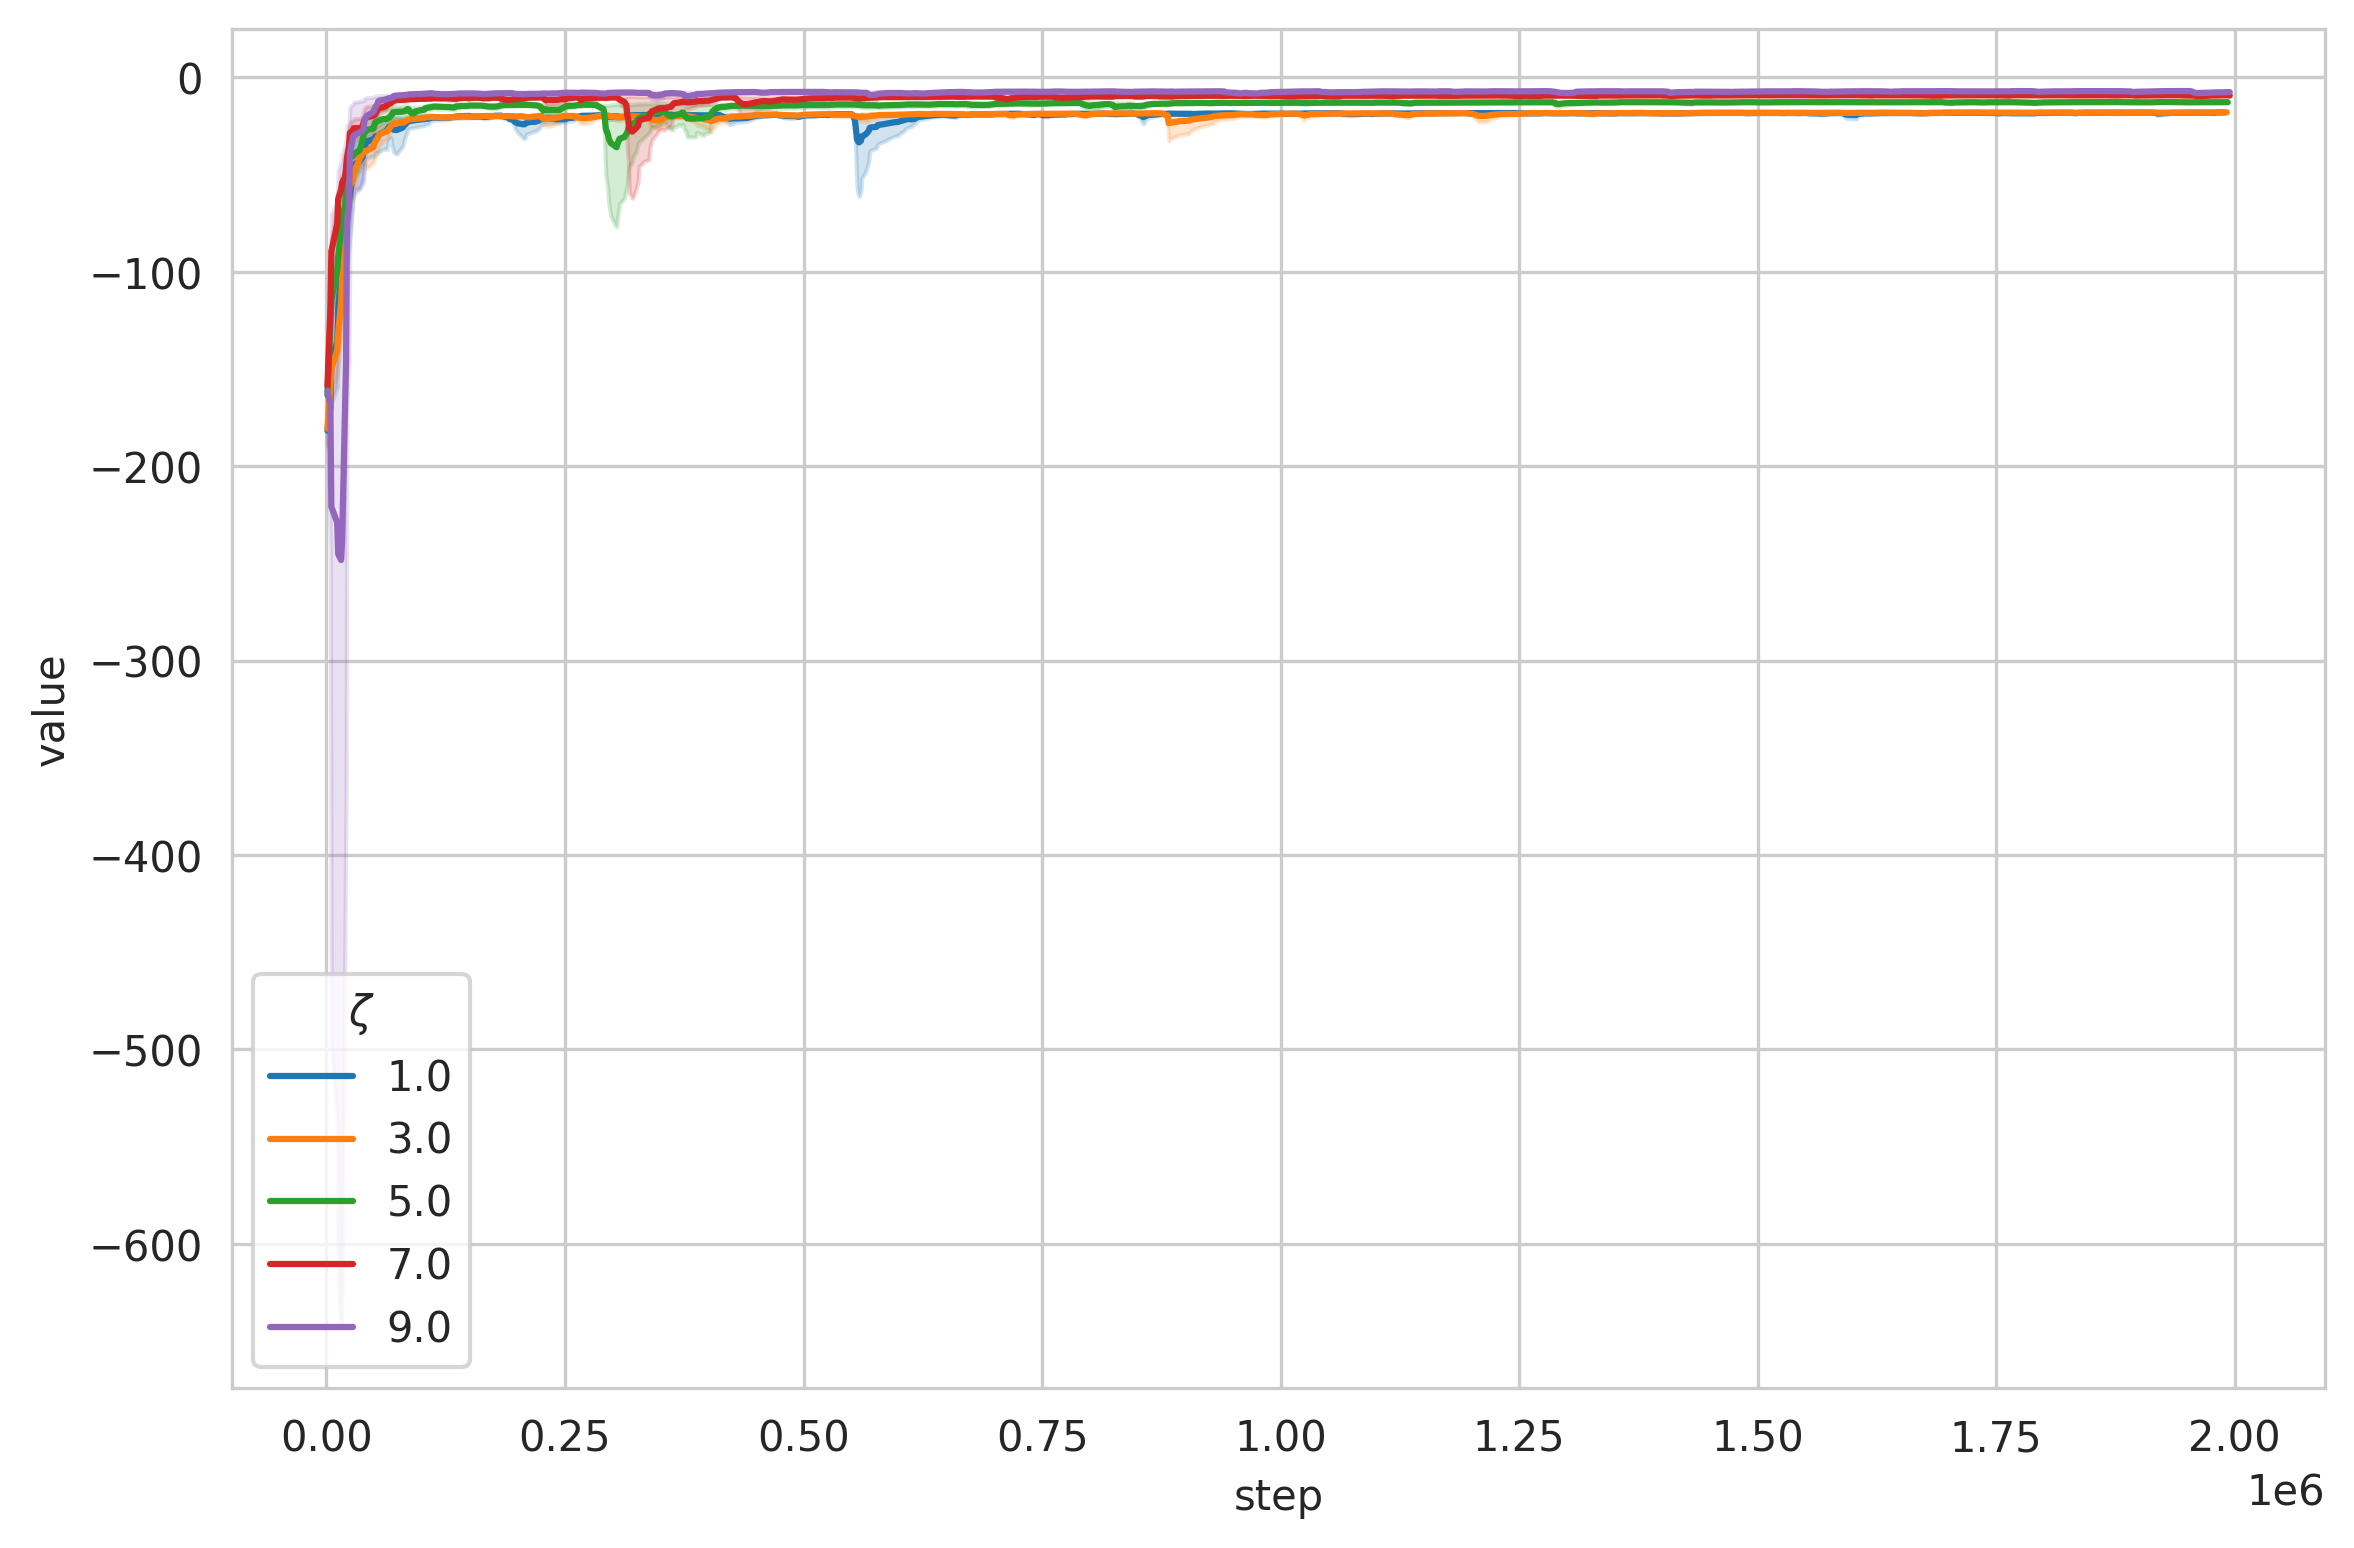

In [253]:
fig = plt.figure(figsize=(9, 6), dpi=300)
sns.lineplot(data=rwd_df, x='step', y='value', hue='$\zeta$', palette='tab10')
# plt.xlim([0, 2e5])

Text(0, 0.5, 'reward')

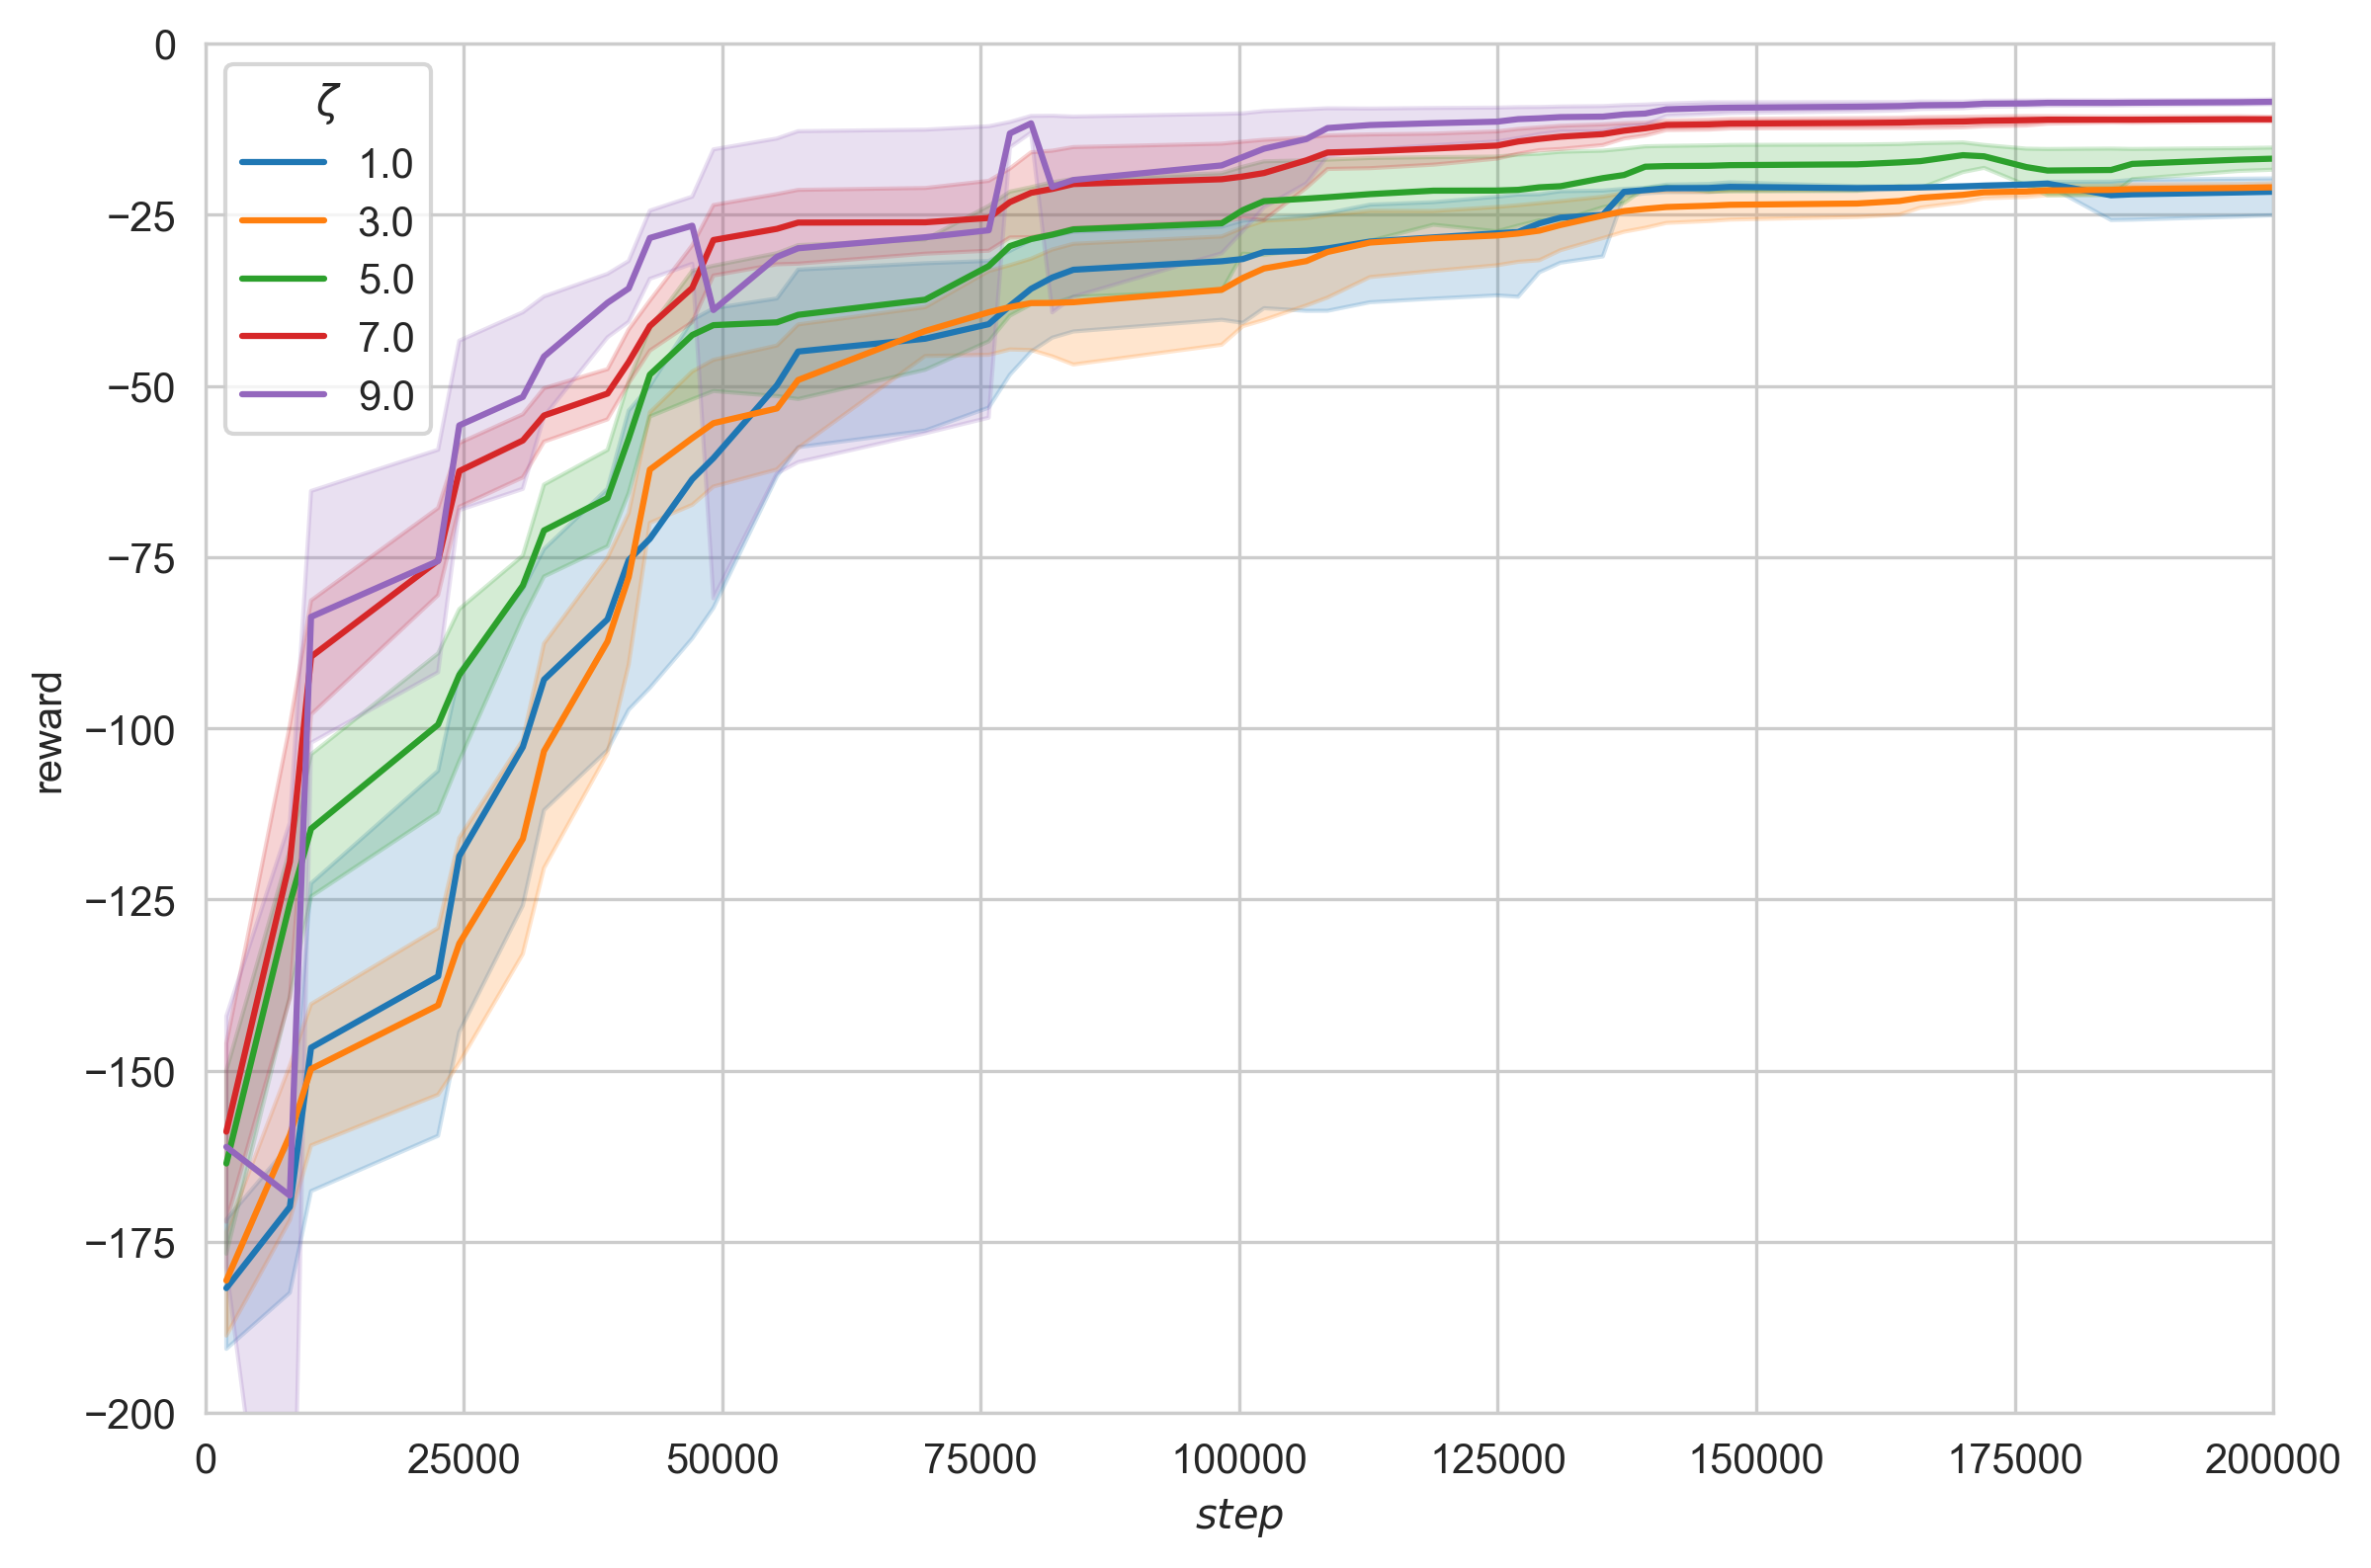

In [11]:
fig = plt.figure(figsize=(9, 6), dpi=300)
sns.lineplot(data=rwd_df, x='step', y='value', hue='$\zeta$', palette='tab10')
plt.xlim([0, 2e5])
plt.ylim([-200, 0])
plt.xlabel('$step$')
plt.ylabel('reward')

(0.0, 4000000.0)

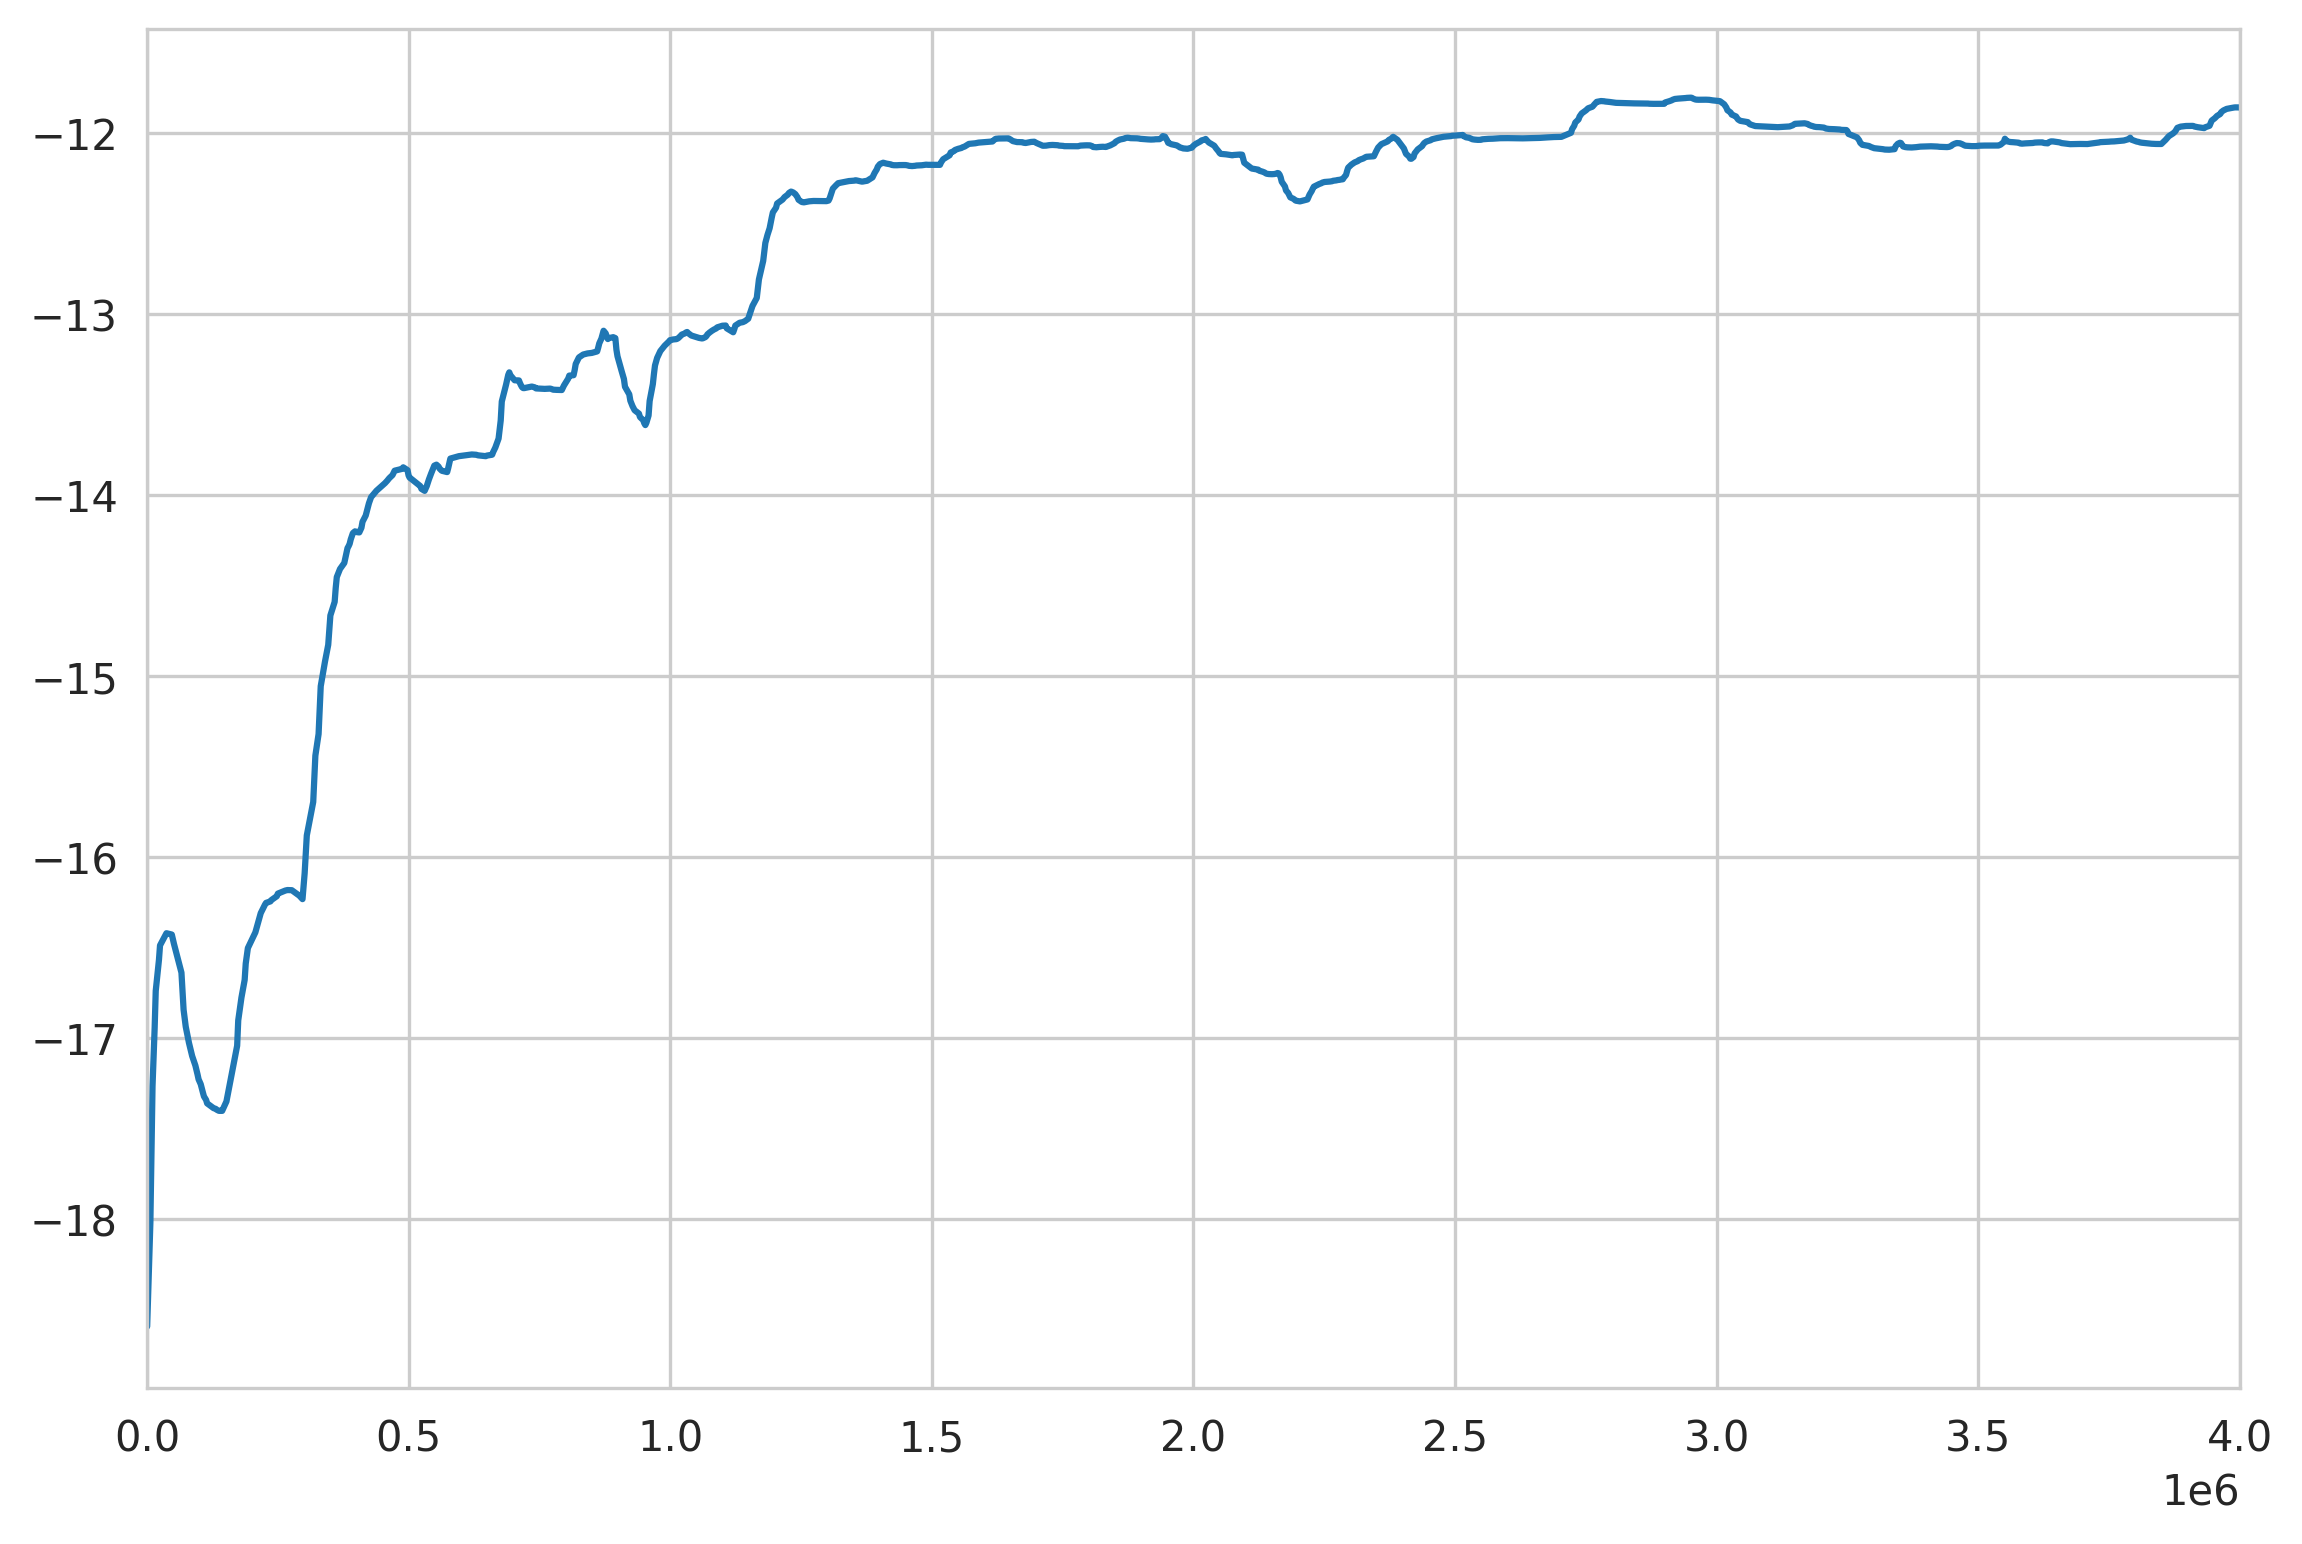

In [26]:
plt.figure(figsize=(9, 6), dpi=300)
plt.plot(step, value)
plt.xlim((0, 4e6))

In [6]:
df = pd.DataFrame()

paths = [] 
for q, r in qr_pairs:
    for adv in advs:
        if adv:
            name = 'adv_q_' + str(q) + '_r_' + str(r)
        else:
            name = 'q_' + str(q) + '_r_' + str(r)
        # paths.append(os.path.join('./results/', name, 'test_record.pkl'))
        path = os.path.join(Params.data_path, name, 'train_record.pkl')
        res = load_pickle(path)
        reward = res['reward']
        reward = reward_cutting(reward, cutting_point=-60)
        reward = reward[100:]
        tmp_df = pd.DataFrame({'iteration': np.array(range(len(reward)))+1, 'value': reward, '$\zeta$':r/q, 'adv':str(adv)})
        df = df.append(tmp_df)
df = df.reset_index(drop=True)
# df['$\zeta$, adv'] = df['$\zeta$'] + " " + df['adv']
# df_qr = df.groupby(['$\zeta$', 'adv'])

# mu = np.array(df.rolling(30).mean().reset_index()['value'])
# std = np.array(df.rolling(30).std().reset_index()['value'])

# df['mu'] = mu
# df['std'] = std

# Performance Plotting without MPC 

In [ ]:
df = pd.DataFrame()

for q, r in qr_pairs:
    for adv in advs:
        if adv:
            name = 'adv_q_' + str(q) + '_r_' + str(r)
        else:
            name = 'q_' + str(q) + '_r_' + str(r)
        # paths.append(os.path.join('./results/', name, 'test_record.pkl'))
        path = os.path.join(Params.data_path, name, 'test_record.pkl')
        res = load_pickle(path)
        data = res['data_df']
        # data['q'] = q
        # data['r'] = r
        data['$\zeta$'] = r / q
        data['adv'] = adv
        df = df.append(data)
df = df.reset_index(drop=True)

In [ ]:
'''
std of du
'''
qr = []
for q, r in qr_pairs:
    qr.append(r/q)

df_std = pd.DataFrame()

for t in range(3):
    for qr_ratio in qr: 
        std = np.zeros((100, 1))
        for adv in advs: 
            df_tmp = df[(df['type'] == 'a') & (df['$\zeta$'] == qr_ratio) & (df['index'] == t + 1) & (df['adv'] == adv)]
            for i in range(10):
                df_num = df_tmp[df_tmp['num_test'] == i + 1]
                std_value = np.array(df_num['value'].rolling(3).std()).reshape(-1, 1)
                df_num['std'] = std_value
                df_std = df_std.append(df_num)
df_std = df_std.reset_index(drop=True)


In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=100)
for t in range(3):
    sns.lineplot(x='step', y='std', data=df_std[df_std['index'] == t + 1], hue='$\zeta$', ax=axs[t], palette='tab10')

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=100)
sns.set_palette('tab10')
ax1 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 1)], hue='$\zeta$', ax=axs[0], palette='tab10')
ax1.set_ylabel('$y_1$')
# ax1.set_title('performance figure')
ax2 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 2)], hue='$\zeta$', legend=None, ax=axs[1], palette='tab10')
ax2.set_ylabel('$y_2$')
ax3 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 3)], hue='$\zeta$', legend=None, ax=axs[2], palette='tab10')
ax3.set_ylabel('$y_3$')
ax3.set_xlabel('step')
# plt.legend(['0.1', '1.0'], title='$\zeta$')

for ax in axs:
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.02, 1.2])

In [ ]:
df_a = df[df['type'] == 'a']
df_a['value'] *= 0.05

In [ ]:
df_a['cum_value'] = df_a.groupby(['num_test', '$\zeta$', 'adv', 'index'])['value'].cumsum()

In [ ]:
a = np.array([3, 2, 1]).reshape(3,)
b = [a]
c = np.array(b).reshape(3, -1)
d = np.pad(c, ((0, 0), (3, 0)))
d

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(16, 6), dpi=300)
ax1 = sns.lineplot(x='step', y='value', data=df_a[(df_a['index'] == 1)], hue='$\zeta$', drawstyle='steps-post', ax=axs[0], palette='tab10')
ax1.set_ylabel('$\Delta u_1$')
# ax1.set_title('performance figure')
ax2 = sns.lineplot(x='step', y='value', data=df_a[(df_a['index'] == 2)], hue='$\zeta$', drawstyle='steps-post', ax=axs[1], palette='tab10', legend=None)
ax2.set_ylabel('$\Delta u_2$')
ax3 = sns.lineplot(x='step', y='value', data=df_a[(df_a['index'] == 3)], hue='$\zeta$', drawstyle='steps-post', ax=axs[2], palette='tab10', legend=None)
ax3.set_ylabel('$\Delta u_3$')
ax3.set_xlabel('step')

# for ax in axs:
#     ax.set_xlim([0, 100])
#     ax.set_ylim([-0.02, 1.2])

for ax in axs:
    ax.set_xlim([1, 100])
    # ax.set_ylim([-0.06, 0.06])

## Criterion Plotting without MPC

In [ ]:
qr_pairs = [
    (1, 2), (1, 5), (1, 8), (1, 15)
]
advs = [False]

'''
use the same qr-pairs in performace plotting section 
'''

indice_df = pd.DataFrame()

for q, r in qr_pairs:
    for adv in advs:
        if adv:
            name = 'adv_q_' + str(q) + '_r_' + str(r)
        else:
            name = 'q_' + str(q) + '_r_' + str(r)
        # paths.append(os.path.join('./results/', name, 'test_record.pkl'))
        path = os.path.join(Params.data_path, name, 'test_record.pkl')
        res = load_pickle(path)
        tmp_df = pd.DataFrame()
        tmp_df = tmp_df.append(pd.DataFrame(data={'value': res['IAE'], 'type': 'IAE'}))
        # tmp_df = tmp_df.append(pd.DataFrame(data={'value': res['ISE'], 'type': 'ISE'}))
        # tmp_df = tmp_df.append(pd.DataFrame(data={'value': res['ITAE'], 'type': 'ITAE'}))
        # tmp_df = tmp_df.append(pd.DataFrame(data={'value': res['ITSE'], 'type': 'ITSE'}))
        tmp_df['$\zeta$'] = r / q 
        tmp_df['adv'] = adv 
        indice_df = indice_df.append(tmp_df)
indice_df = indice_df.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(9, 6), dpi=100)
ax = sns.boxplot(data=indice_df, x='type', y='value', hue='$\zeta$', width=0.6)
ax.set_xlabel(None)

## Performance Plotting with MPC 

In [ ]:
'''
load mpc data
'''

mpc_df = pd.DataFrame() 

for i in range(10):
    mpc_y = io.loadmat('./MPC_result/ysim_'+str(i+1)+'.mat')['ysim']
    '''
    ['type', 'value', 'num_test', 'index', 'step']
    '''
    data = [] 
    for j in range(mpc_y.shape[0]):
        data.append(['y', mpc_y[j, 0], i + 1, 1, j + 1])
        data.append(['y', mpc_y[j, 1], i + 1, 2, j + 1])
        data.append(['y', mpc_y[j, 2], i + 1, 3, j + 1])
    mpc_df = mpc_df.append(
        pd.DataFrame(
            data = data,
            columns=['type', 'value', 'num_test', 'index', 'step']
        ).sort_values(by=['num_test', 'index', 'step'])
    )
mpc_df = mpc_df.reset_index(drop=True)

In [ ]:
mpc_df

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(9, 6), dpi=300)
sns.set_palette('tab10')
ax1 = sns.lineplot(x='step', y='value', data=mpc_df[mpc_df['index'] == 1], ax=axs[0], label='MPC')
ax1 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 1) & (df['adv'] == True)], ax=axs[0], label='RL with adv')
ax1 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 1) & (df['adv'] == False)], ax=axs[0], label='RL without adv')
ax1.set_ylabel('$y_1$')
ax1.set_title('performance figure')
ax1.legend()
ax2 = sns.lineplot(x='step', y='value', data=mpc_df[mpc_df['index'] == 2], ax=axs[1])
ax2 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 2) & (df['adv'] == True)], ax=axs[1])
ax2 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 2) & (df['adv'] == False)], ax=axs[1])
ax2.set_ylabel('$y_2$')
ax3 = sns.lineplot(x='step', y='value', data=mpc_df[mpc_df['index'] == 3], ax=axs[2])
ax3 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 3) & (df['adv'] == True)], ax=axs[2])
ax3 = sns.lineplot(x='step', y='value', data=df[(df['type'] == 'y') & (df['index'] == 3) & (df['adv'] == False)], ax=axs[2])
ax3.set_ylabel('$y_3$')
ax3.set_xlabel('step')